##### **Importing Libraries:**

In [16]:
import requests
from bs4 import BeautifulSoup
import csv, json
from urllib.parse import urljoin
import pandas as pd
import re 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

##### **Data Extraction:**

In [2]:
base_url = 'https://books.toscrape.com'
page_url = 'https://books.toscrape.com/catalogue/page-{}.html'

In [7]:
rating_map = {
    'One': 1,
    'Two': 2,
    'Three': 3,
    'Four': 4,
    'Five': 5
}

booksData = []

for page in range(1, 51):
    
    print(f'Scraping page-{page}...')
    
    if page == 1:
        url = base_url
    else:
        url = page_url.format(page)
        

    res = requests.get(url)
    soup = BeautifulSoup(res.text, 'html.parser')

    for book in soup.select('article.product_pod'):
        title = book.h3.a['title']
        price = book.select_one('.price_color').text
        availability = book.select_one('.availability').text.strip()

        rating_class = book.select_one('p.star-rating')['class']
        star_word = [cls for cls in rating_class if cls != 'star-rating'][0]
        stars = rating_map.get(star_word, 0)

        relative_link = book.h3.a['href']
        if 'catalogue/' not in relative_link:
            relative_link = 'catalogue/' + relative_link
        book_url = urljoin(base_url, relative_link)

        detail_res = requests.get(book_url)
        detail_soup = BeautifulSoup(detail_res.text, 'html.parser')

        desc_tag = detail_soup.select_one('#product_description ~ p')
        description = desc_tag.text.strip() if desc_tag else None

        table = detail_soup.select_one('table.table.table-striped')
        info = {row.th.text: row.td.text for row in table.select('tr')} if table else None
        upc = info.get('UPC', '') if info else None


        genre_tags = detail_soup.select('ul.breadcrumb li > a')
        
        genre_tag = genre_tags[2].text.strip() if len(genre_tags) > 2 else None


        booksData.append({
            'title': title,
            'price': price,
            'availability': availability,
            'stars': stars,
            'url': book_url,
            'description': description,
            'upc': upc,
            'genre': genre_tag,
        })

Scraping page-1...
Scraping page-2...
Scraping page-3...
Scraping page-4...
Scraping page-5...
Scraping page-6...
Scraping page-7...
Scraping page-8...
Scraping page-9...
Scraping page-10...
Scraping page-11...
Scraping page-12...
Scraping page-13...
Scraping page-14...
Scraping page-15...
Scraping page-16...
Scraping page-17...
Scraping page-18...
Scraping page-19...
Scraping page-20...
Scraping page-21...
Scraping page-22...
Scraping page-23...
Scraping page-24...
Scraping page-25...
Scraping page-26...
Scraping page-27...
Scraping page-28...
Scraping page-29...
Scraping page-30...
Scraping page-31...
Scraping page-32...
Scraping page-33...
Scraping page-34...
Scraping page-35...
Scraping page-36...
Scraping page-37...
Scraping page-38...
Scraping page-39...
Scraping page-40...
Scraping page-41...
Scraping page-42...
Scraping page-43...
Scraping page-44...
Scraping page-45...
Scraping page-46...
Scraping page-47...
Scraping page-48...
Scraping page-49...
Scraping page-50...


##### **Saving data:**

In [8]:
with open('books.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.DictWriter(f, fieldnames=booksData[0].keys())
    writer.writeheader()
    writer.writerows(booksData)

In [9]:
with open('books.json', 'w', encoding='utf-8') as f:
    json.dump(booksData, f, indent=4, ensure_ascii=False)

##### **Data Cleaning & Processing:**

In [2]:
df = pd.read_csv('books.csv')

df.sample(10)

,title,price,availability,stars,url,description,upc,genre
83,"Political Suicide: Missteps, Peccadilloes, Bad...",Â£36.28,In stock,2,https://books.toscrape.com/catalogue/political...,Just in time for the presidential election of ...,7392c0032f92d816,History
263,Steve Jobs,Â£39.50,In stock,5,https://books.toscrape.com/catalogue/steve-job...,From best-selling author Walter Isaacson comes...,95019eac1c0a052f,Default
322,City of Glass (The Mortal Instruments #3),Â£56.02,In stock,4,https://books.toscrape.com/catalogue/city-of-g...,Also see: Alternate Cover Editions for this IS...,966ebb738e0f9d9b,Fantasy
968,Matilda,Â£28.34,In stock,1,https://books.toscrape.com/catalogue/matilda_3...,Matilda is a little girl who is far too good t...,1053fb7ee17a1f33,Childrens
433,Nap-a-Roo,Â£25.08,In stock,1,https://books.toscrape.com/catalogue/nap-a-roo...,"Finalist, 9th Annual National Indie Excellence...",913e7109cec0cb4c,Childrens
300,Hold Your Breath (Search and Rescue #1),Â£28.82,In stock,1,https://books.toscrape.com/catalogue/hold-your...,"In the remote Rocky Mountains, lives depend on...",0b165bd4b9f42fd5,Romance
956,"Paper Girls, Vol. 1 (Paper Girls #1-5)",Â£21.71,In stock,4,https://books.toscrape.com/catalogue/paper-gir...,"In the early hours after Halloween of 1988, fo...",bcbcbcf0f6ed196f,Sequential Art
26,America's Cradle of Quarterbacks: Western Penn...,Â£22.50,In stock,3,https://books.toscrape.com/catalogue/americas-...,"Any fan of the Baltimore Colts of my era, any ...",c7d160c2c0de586f,Default
219,Why the Right Went Wrong: Conservatism--From G...,Â£52.65,In stock,4,https://books.toscrape.com/catalogue/why-the-r...,âDionne's expertise is evident in this finel...,2b5054a4192e9b06,Politics
468,"Love That Boy: What Two Presidents, Eight Road...",Â£25.06,In stock,2,https://books.toscrape.com/catalogue/love-that...,"Tyler and I inch toward the Green Room, in lin...",4d3a4c7b442a9a4e,Nonfiction


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         1000 non-null   object
 1   price         1000 non-null   object
 2   availability  1000 non-null   object
 3   stars         1000 non-null   int64 
 4   url           1000 non-null   object
 5   description   998 non-null    object
 6   upc           1000 non-null   object
 7   genre         1000 non-null   object
dtypes: int64(1), object(7)
memory usage: 62.6+ KB


In [3]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 998 entries, 0 to 999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         998 non-null    object
 1   price         998 non-null    object
 2   availability  998 non-null    object
 3   stars         998 non-null    int64 
 4   url           998 non-null    object
 5   description   998 non-null    object
 6   upc           998 non-null    object
 7   genre         998 non-null    object
dtypes: int64(1), object(7)
memory usage: 70.2+ KB


In [5]:
df.duplicated().sum()

np.int64(0)

In [4]:
df['price'] = df['price'].apply(lambda x: re.sub(r'Â£','', x))
df.head()

,title,price,availability,stars,url,description,upc,genre
0,A Light in the Attic,51.77,In stock,3,https://books.toscrape.com/catalogue/a-light-i...,It's hard to imagine a world without A Light i...,a897fe39b1053632,Poetry
1,Tipping the Velvet,53.74,In stock,1,https://books.toscrape.com/catalogue/tipping-t...,"""Erotic and absorbing...Written with starling ...",90fa61229261140a,Historical Fiction
2,Soumission,50.10,In stock,1,https://books.toscrape.com/catalogue/soumissio...,"Dans une France assez proche de la nÃ´tre, un ...",6957f44c3847a760,Fiction
3,Sharp Objects,47.82,In stock,4,https://books.toscrape.com/catalogue/sharp-obj...,"WICKED above her hipbone, GIRL across her hear...",e00eb4fd7b871a48,Mystery
4,Sapiens: A Brief History of Humankind,54.23,In stock,5,https://books.toscrape.com/catalogue/sapiens-a...,From a renowned historian comes a groundbreaki...,4165285e1663650f,History


In [5]:
#fix dtype for price col
df['price']=df['price'].astype('float')
df.dtypes

title            object
price           float64
availability     object
stars             int64
url              object
description      object
upc              object
genre            object
dtype: object

In [6]:
#We are making sure the URL is correct using regex
matches=df.url.apply(lambda x: bool(re.match(r'https://books.toscrape.com/catalogue/[\w-]+/index.html',x)))
df=df[matches]
df.head()

,title,price,availability,stars,url,description,upc,genre
0,A Light in the Attic,51.77,In stock,3,https://books.toscrape.com/catalogue/a-light-i...,It's hard to imagine a world without A Light i...,a897fe39b1053632,Poetry
1,Tipping the Velvet,53.74,In stock,1,https://books.toscrape.com/catalogue/tipping-t...,"""Erotic and absorbing...Written with starling ...",90fa61229261140a,Historical Fiction
2,Soumission,50.10,In stock,1,https://books.toscrape.com/catalogue/soumissio...,"Dans une France assez proche de la nÃ´tre, un ...",6957f44c3847a760,Fiction
3,Sharp Objects,47.82,In stock,4,https://books.toscrape.com/catalogue/sharp-obj...,"WICKED above her hipbone, GIRL across her hear...",e00eb4fd7b871a48,Mystery
4,Sapiens: A Brief History of Humankind,54.23,In stock,5,https://books.toscrape.com/catalogue/sapiens-a...,From a renowned historian comes a groundbreaki...,4165285e1663650f,History


##### **Data Analysis and Visualization:**

In [9]:
data=df.groupby('genre')['stars'].mean().round()
df.genre.unique()

array(['Poetry', 'Historical Fiction', 'Fiction', 'Mystery', 'History',
       'Young Adult', 'Business', 'Default', 'Sequential Art', 'Music',
       'Science Fiction', 'Politics', 'Travel', 'Thriller',
       'Food and Drink', 'Romance', 'Childrens', 'Nonfiction', 'Art',
       'Spirituality', 'Philosophy', 'New Adult', 'Contemporary',
       'Fantasy', 'Add a comment', 'Science', 'Health', 'Horror',
       'Self Help', 'Religion', 'Christian', 'Crime', 'Autobiography',
       'Christian Fiction', 'Biography', 'Womens Fiction', 'Erotica',
       'Cultural', 'Psychology', 'Humor', 'Historical', 'Novels',
       'Short Stories', 'Suspense', 'Classics', 'Academic',
       'Sports and Games', 'Adult Fiction', 'Parenting', 'Paranormal'],
      dtype=object)

C:\Users\CAVO\AppData\Local\Temp\ipykernel_18700\3852918838.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=data.index,x=data.values,palette='viridis')


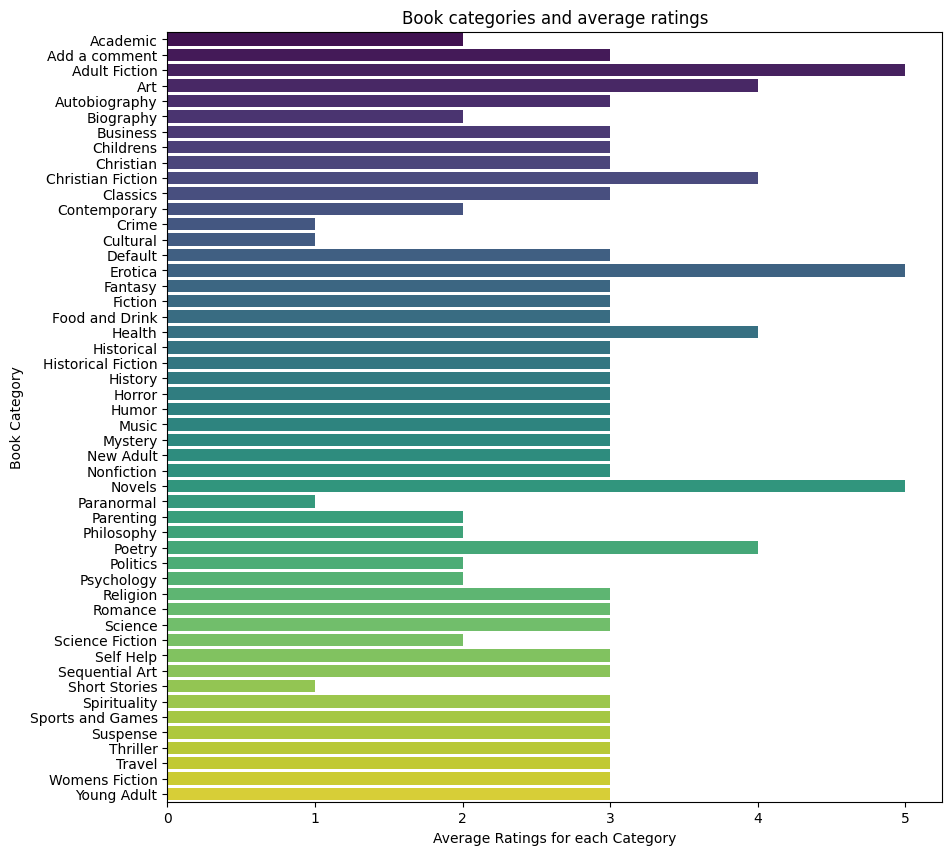

In [16]:
plt.figure(figsize=(10,10))
sns.barplot(y=data.index,x=data.values,palette='viridis')
plt.ylabel('Book Category')
plt.xlabel('Average Ratings for each Category')
plt.title('Book categories and average ratings')
plt.show()

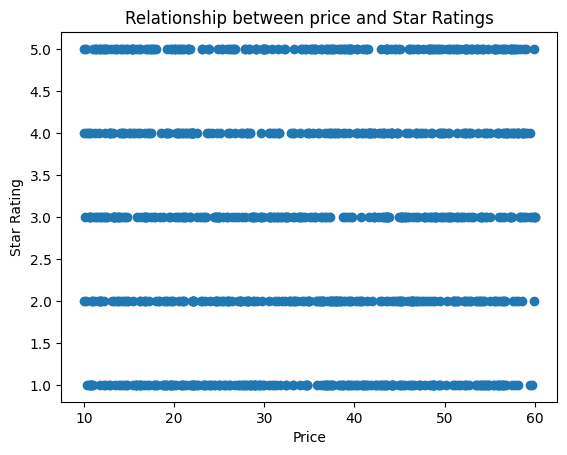

In [17]:
plt.scatter(df.price,df.stars)
plt.title('Relationship between price and Star Ratings')
plt.xlabel('Price')
plt.ylabel('Star Rating')
plt.show()

A plot showing no relationship between book price and ratings.

In [7]:
categories=df.genre.value_counts().reset_index()
categories=categories.sort_values(by='count', ascending=False).head(10)
categories

,genre,count
0,Default,151
1,Nonfiction,110
2,Sequential Art,75
3,Add a comment,67
4,Fiction,65
5,Young Adult,54
6,Fantasy,48
7,Romance,35
8,Mystery,32
9,Food and Drink,30


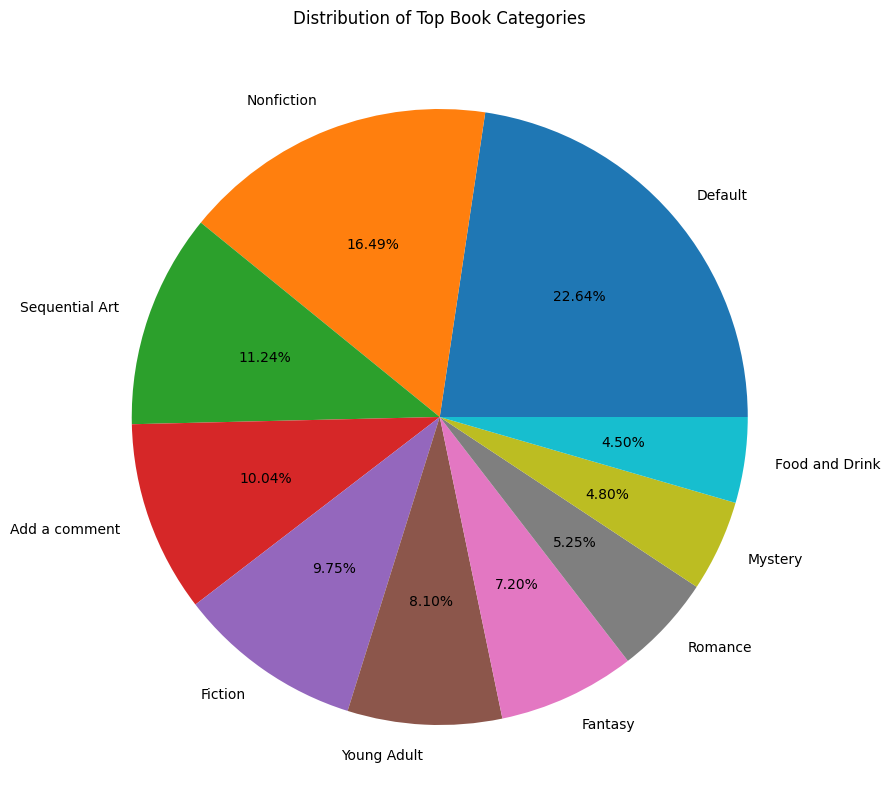

In [8]:
plt.figure(figsize=(10,10))
plt.pie(categories['count'],labels=categories['genre'],autopct='%0.2f%%')
plt.title('Distribution of Top Book Categories')
plt.show()

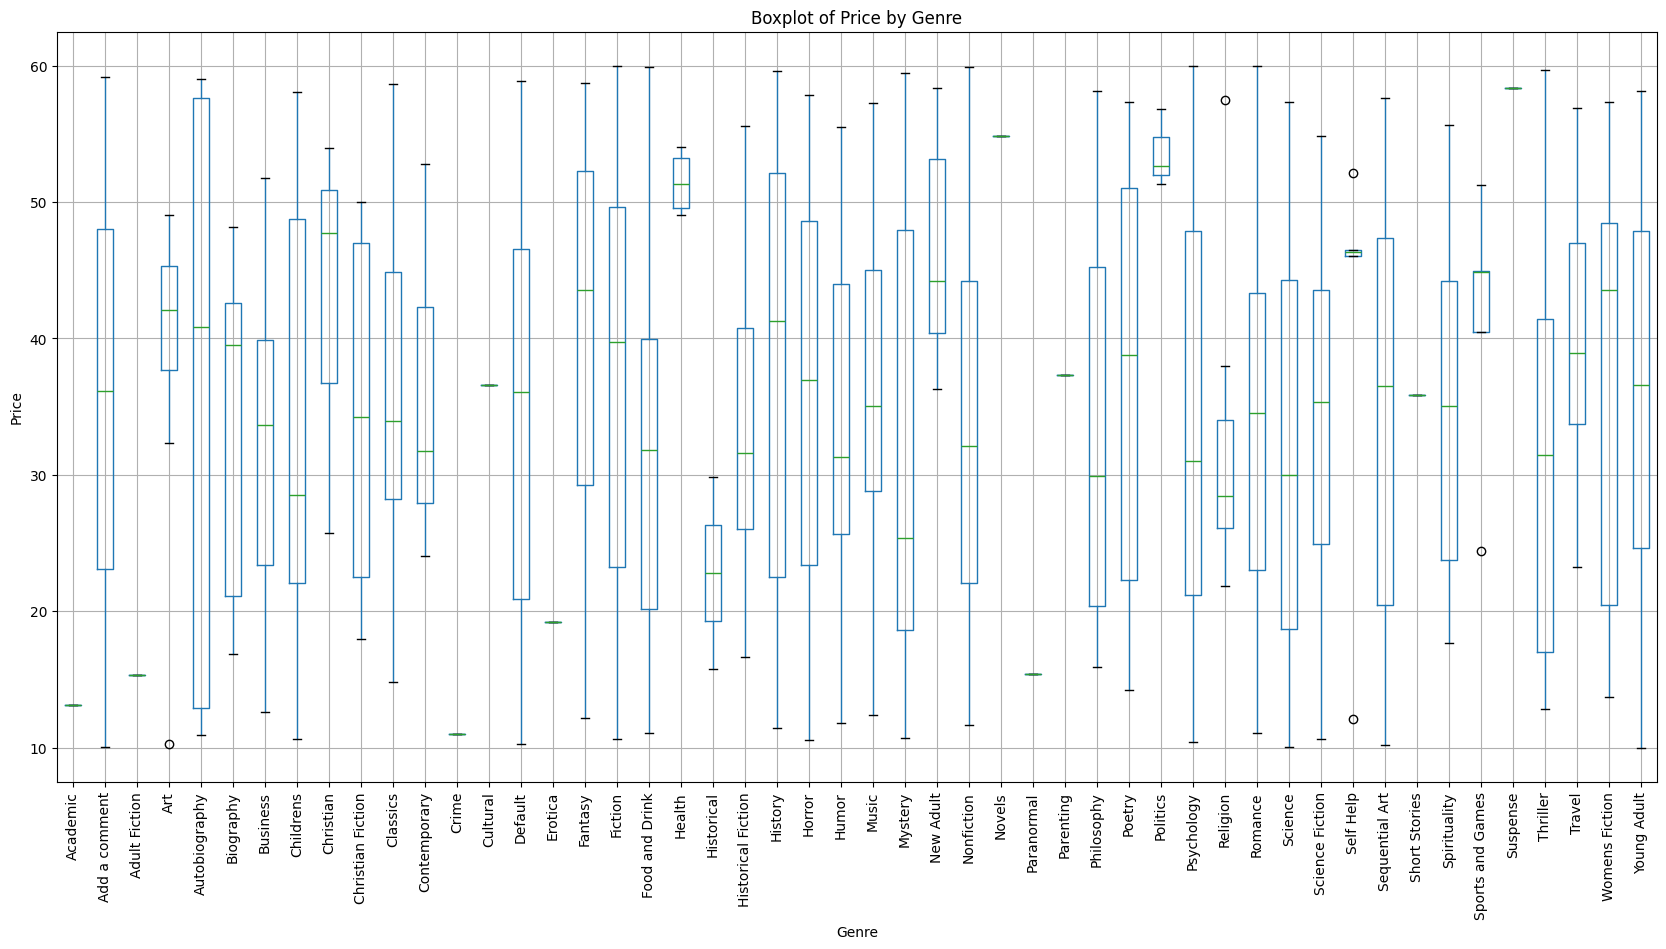

In [15]:
data = df[['genre', 'price']]

fig, ax = plt.subplots(figsize=(20, 10))
data.boxplot(by='genre', rot=90, ax=ax)

ax.set_title('Boxplot of Price by Genre')
plt.suptitle('')
ax.set_xlabel('Genre')
ax.set_ylabel('Price')

plt.show()

In [17]:
#visualize word cloud for sequentil art descreption and see the most frequent words in this genre
art_description=df[df['genre']=='Sequential Art']
art_description.sample(6)

,title,price,availability,stars,url,description,upc,genre
93,"Lumberjanes, Vol. 2: Friendship to the Max (Lu...",46.91,In stock,2,https://books.toscrape.com/catalogue/lumberjan...,"What a mystery!Jo, April, Mal, Molly, and Ripl...",460089f796fb3f82,Sequential Art
841,"Fruits Basket, Vol. 3 (Fruits Basket #3)",45.17,In stock,2,https://books.toscrape.com/catalogue/fruits-ba...,A family with an ancient curse...And the girl ...,d5f5a122a593b580,Sequential Art
279,"Naruto (3-in-1 Edition), Vol. 14: Includes Vol...",38.39,In stock,2,https://books.toscrape.com/catalogue/naruto-3-...,Naruto is a young shinobi with an incorrigible...,71e36f33981ddb74,Sequential Art
86,orange: The Complete Collection 1 (orange: The...,48.41,In stock,1,https://books.toscrape.com/catalogue/orange-th...,A Plea From the FutureOn the day that Naho beg...,11809b1d323b3057,Sequential Art
111,Danganronpa Volume 1,51.99,In stock,4,https://books.toscrape.com/catalogue/danganron...,"Each year, the elite Hope's Peak Academy selec...",09b6cc87e62c2c58,Sequential Art
890,"The Sandman, Vol. 2: The Doll's House (The San...",54.81,In stock,1,https://books.toscrape.com/catalogue/the-sandm...,A being who has existed since the beginning of...,276dc716b1da8899,Sequential Art


In [18]:
art_description_text=' '.join(art_description['description'])
art_description_text

'Scott Pilgrim\'s life is totally sweet. He\'s 23 years old, he\'s in a rockband, he\'s "between jobs" and he\'s dating a cute high school girl. Nothing could possibly go wrong, unless a seriously mind-blowing, dangerously fashionable, rollerblading delivery girl named Ramona Flowers starts cruising through his dreams and sailing by him at parties. Will Scott\'s awesome life get Scott Pilgrim\'s life is totally sweet. He\'s 23 years old, he\'s in a rockband, he\'s "between jobs" and he\'s dating a cute high school girl. Nothing could possibly go wrong, unless a seriously mind-blowing, dangerously fashionable, rollerblading delivery girl named Ramona Flowers starts cruising through his dreams and sailing by him at parties. Will Scott\'s awesome life get turned upside-down? Will he have to face Ramona\'s seven evil ex-boyfriends in battle? The short answer is yes. The long answer is Scott Pilgrim, Volume 1: Scott Pilgrim\'s Precious Little Life ...more DUAL WORLDS, DUAL SIGHTS In the lan

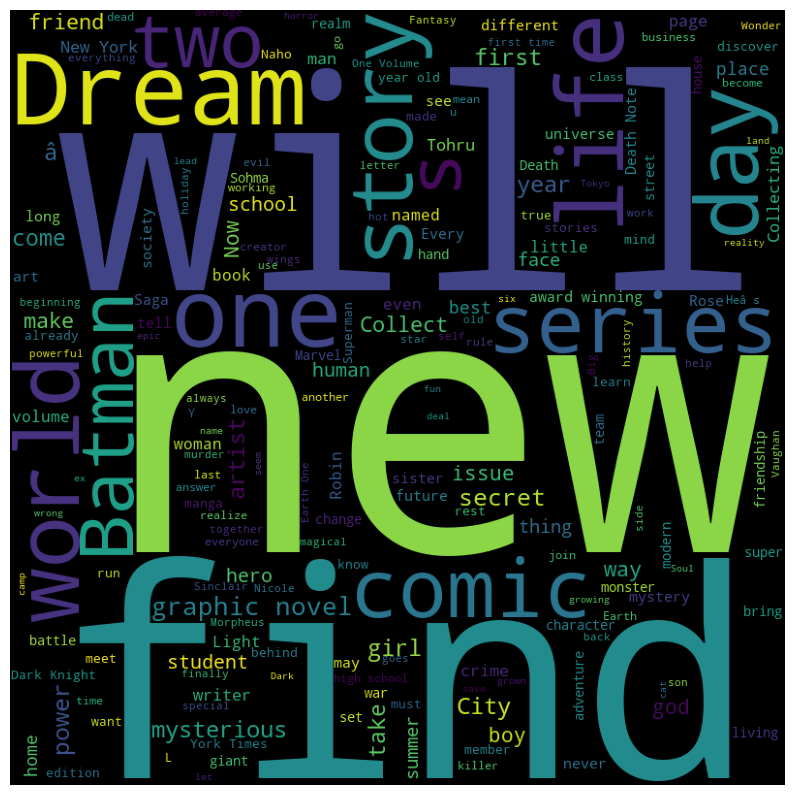

In [19]:
word=WordCloud(width=800,height=800).generate(art_description_text)
plt.figure(figsize=(10,15))
plt.imshow(word)
plt.axis('off')
plt.show()